In [1]:
import yt
import yt.units as u
import sys

## Load the FLASH file

In [2]:
ds = yt.load("../../TDE_plot/multitidal_hdf5_plt_cnt_0031")
ds

yt : [INFO     ] 2020-11-23 13:03:43,489 Parameters: current_time              = 33251.250750886196
yt : [INFO     ] 2020-11-23 13:03:43,494 Parameters: domain_dimensions         = [8 8 8]
yt : [INFO     ] 2020-11-23 13:03:43,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-11-23 13:03:43,500 Parameters: domain_right_edge         = [4.96154e+13 4.96154e+13 2.48077e+12]
yt : [INFO     ] 2020-11-23 13:03:43,503 Parameters: cosmological_simulation   = 0.0


multitidal_hdf5_plt_cnt_0031

In [3]:
ds.print_stats()

/Users/chang/opt/anaconda3/lib/python3.8/site-packages/yt/units/yt_array.py:978: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ret = super(YTArray, self).__getitem__(item)
/Users/chang/opt/anaconda3/lib/python3.8/site-packages/yt/fields/fluid_fields.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_field[slice_3d] = f


level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	     1	           512	             8
  1	     8	          4096	            16
  2	    64	         32768	            32
  3	   512	        262144	            64
  4	   752	        385024	            73
  5	  1008	        516096	            81
  6	  1520	        778240	            92
  7	  3472	       1777664	           122
  8	 10720	       5488640	           177
  9	 40064	      20512768	           274
----------------------------------------------
   	 58121	      29757952


t = 3.32512508e+04 = 3.32512508e+04 s = 1.05366855e-03 years

Smallest Cell:
	Width: 3.926e-15 Mpc
	Width: 3.926e-09 pc
	Width: 8.097e-04 AU
	Width: 1.211e+10 cm


## Basic Information
### Statistics about the simulation
- Original
- Derived

In [4]:
#ds.field_list

In [5]:
#ds.derived_field_list

### Domain of the simulation

In [6]:
ds.domain_width.in_units("au")

YTArray([3.31658464, 3.31658464, 0.16582923]) au

## Simple Visualization
### Projection
- A line integral through the domain

yt : [INFO     ] 2020-11-23 13:06:52,412 xlim = 0.000000 49615400000000.000000
yt : [INFO     ] 2020-11-23 13:06:52,413 ylim = 0.000000 49615400000000.000000
yt : [INFO     ] 2020-11-23 13:06:52,414 xlim = 0.000000 49615400000000.000000
yt : [INFO     ] 2020-11-23 13:06:52,416 ylim = 0.000000 49615400000000.000000
yt : [INFO     ] 2020-11-23 13:06:52,419 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



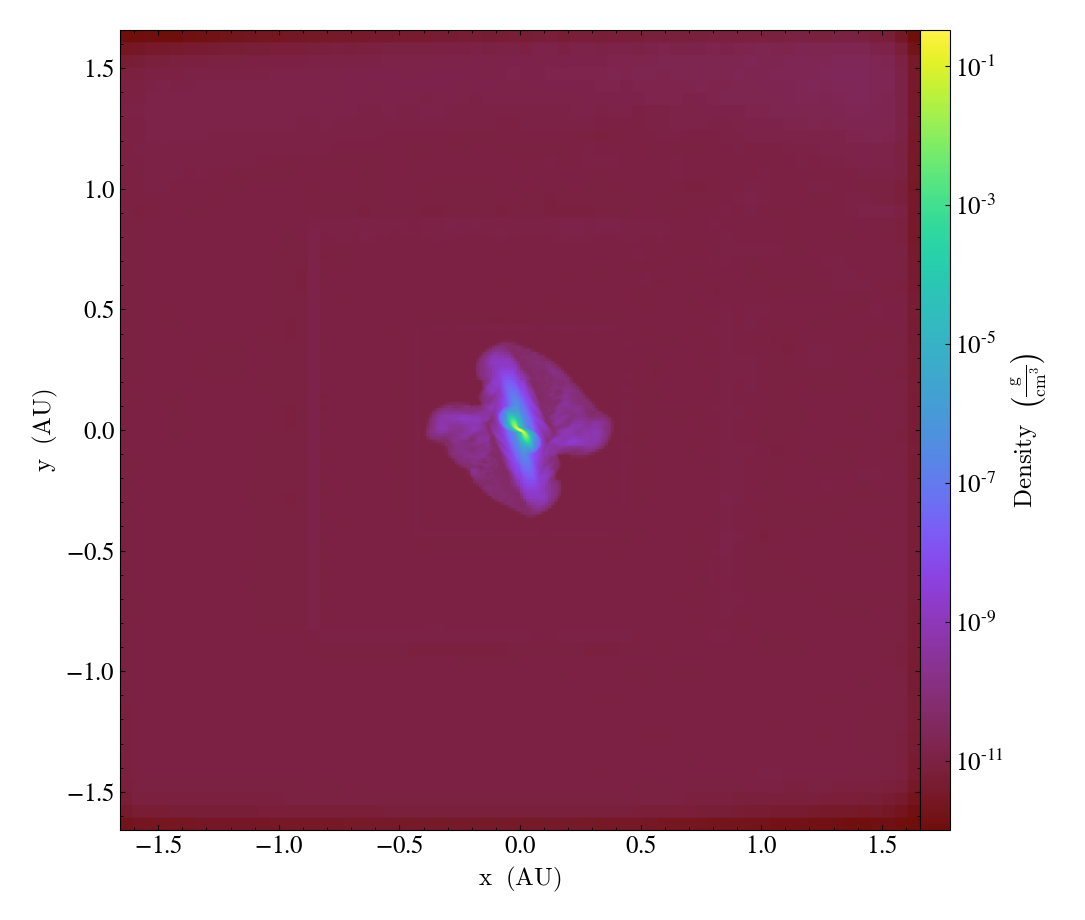

In [13]:
pp = yt.SlicePlot(ds, "z", ["density"])
pp

yt : [INFO     ] 2020-11-23 13:06:53,338 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



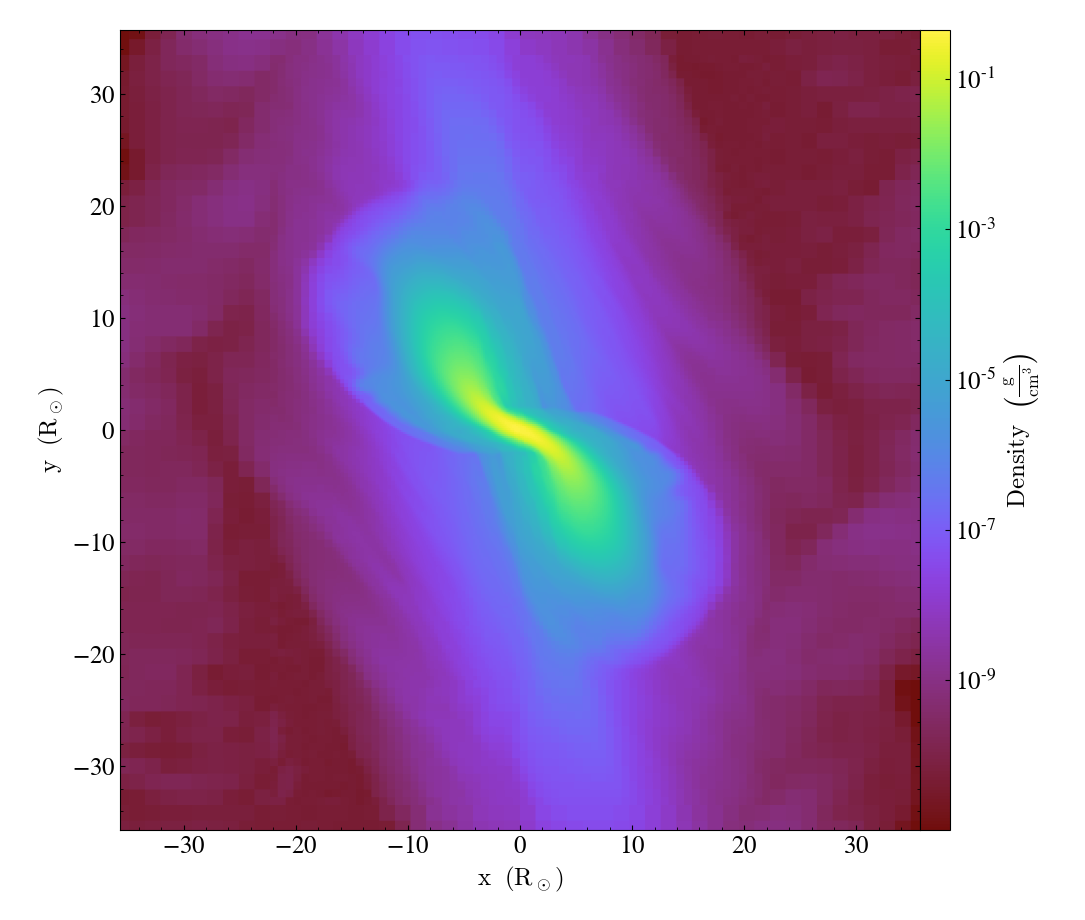

In [14]:
pp.zoom(10)

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
da = ds.all_data()

In [17]:
da['particle_posx'].in_units('AU')/ds.domain_width.in_units("au"), da['particle_posy'].in_units('AU'), da['particle_posz'].in_units('AU')

(YTArray([0.49986412, 0.49986412, 9.99728237]) AU/au,
 YTArray([1.6583061]) AU,
 YTArray([0.08291436]) AU)

In [18]:
da['particle_velx'].in_units('km/s'), da['particle_vely'].in_units('km/s'), da['particle_velz'].in_units('km/s')

(YTArray([-164.95900448]) km/s,
 YTArray([-34.85745528]) km/s,
 YTArray([0.00121558]) km/s)